# Time Series Forecasting using Python - Jet Rail
**REFERENCES USED**
- Time Series Concepts
> https://www.abs.gov.au/websitedbs/d3310114.nsf/home/time+series+analysis:+the+basics
- Detailed Explaination of Time Series concepts 
> https://www.machinelearningplus.com/time-series/time-series-analysis-python/
- Detailed Explaination of Time Series concepts  (Arima)
> https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/#:~:text=ARIMA%2C%20short%20for%20'Auto%20Regressive,used%20to%20forecast%20future%20values
- Time Series for Arima and ACF and PACF plots explained clearly 
> https://www.kaggle.com/freespirit08/time-series-for-beginners-with-arima

In [2]:
import pandas as pd          
import numpy as np    
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt  
import seaborn as sns
from datetime import datetime     
from pandas import Series      

%matplotlib inline 
import warnings                   
warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (12, 7)

## Problem Statement

Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! The investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months. In order to help Unicorn Ventures in their decision, **you need to forecast the traffic on JetRail for the next 7 months.** You are provided with traffic data of JetRail since inception in the test file

In [3]:
train = pd.read_csv("data1/Train_SU63ISt.csv")
test = pd.read_csv("data1/Test_0qrQsBZ.csv")
subm = pd.read_csv("data1/sample_submission_LSeus50.csv")

## Hypothesis Generation
 
**Below are some of the hypotheses which I think can affect the passenger count(dependent variable for this time series problem) on the JetRail**

* 1. There will be an increase in the traffic as the years pass by.
Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers as later in time 

* 2. Traffic on weekdays will be more as compared to weekends/holidays.
Explanation - People will go to office on weekdays and hence the traffic will be more

* 3. Traffic during the peak hours will be high.
Explanation - People will travel to work, college.


In [4]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        18288 non-null  int64 
 1   Datetime  18288 non-null  object
 2   Count     18288 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 428.8+ KB


In [6]:
train.describe()

,ID,Count
count,18288.000000,18288.000000
mean,9143.500000,138.958115
std,5279.435197,153.467461
min,0.000000,2.000000
25%,4571.750000,22.000000
50%,9143.500000,84.000000
75%,13715.250000,210.000000
max,18287.000000,1244.000000


In [7]:
# Changing datetime to its original type instead of object

train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 

for data in (train, test):
    data['year']=data["Datetime"].dt.year 
    data['month']=data["Datetime"].dt.month 
    data['day']=data["Datetime"].dt.day
    data['Hour']=data["Datetime"].dt.hour

In [8]:
train.head()

,ID,Datetime,Count,year,month,day,Hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [9]:
test.head()

,ID,Datetime,year,month,day,Hour
0,18288,2014-09-26 00:00:00,2014,9,26,0
1,18289,2014-09-26 01:00:00,2014,9,26,1
2,18290,2014-09-26 02:00:00,2014,9,26,2
3,18291,2014-09-26 03:00:00,2014,9,26,3
4,18292,2014-09-26 04:00:00,2014,9,26,4


## EDA

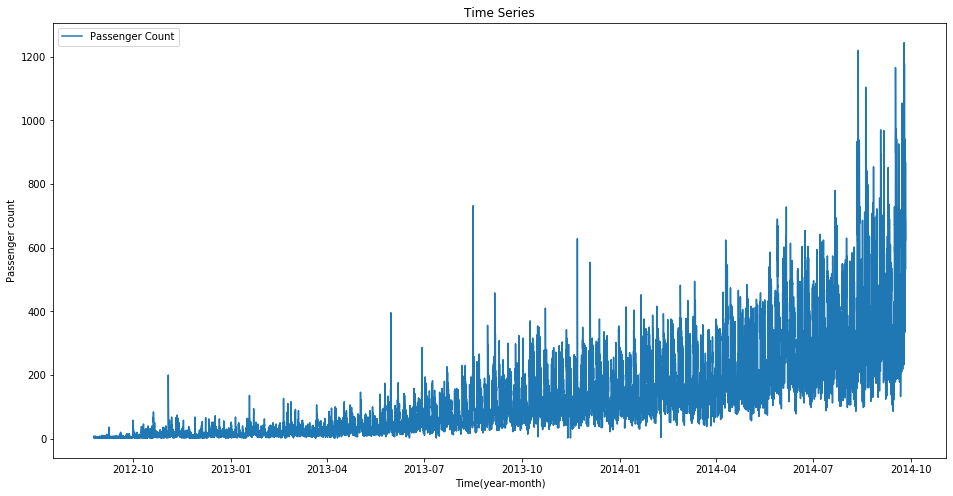

In [10]:

train['day of week']=train['Datetime'].dt.dayofweek 
temp = train['Datetime']
# assigning 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2


train.index = train['Datetime'] # indexing the Datetime to get the time period on the x-axis. 
df=train.drop('ID',1)           # drop ID variable to get only the Datetime on x-axis. 
ts = df['Count'] 
plt.figure(figsize=(16,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("Passenger count") 
plt.legend(loc='best');

## Inference from graph

- There is an increasing trend in the series, i.e., the number of count is increasing with respect to time.

- At certain points there is a sudden increase in the number of counts. The possible reason behind this could be that on particular day, due to some event the traffic was high.



## Exploring Hypothesis


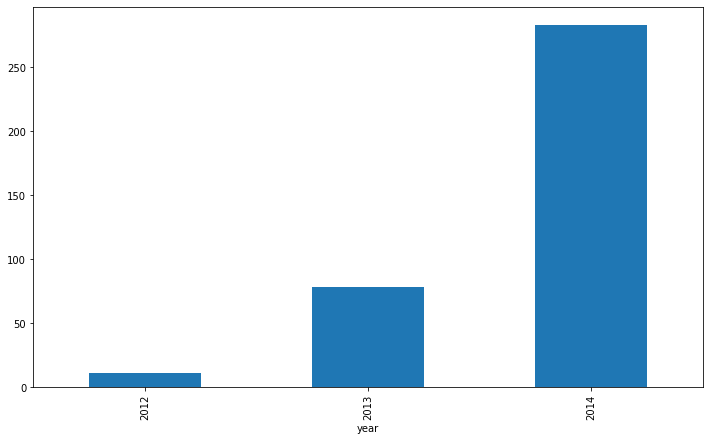

In [11]:
#first hypothesis was traffic will increase as the years pass by.
train.groupby('year')['Count'].mean().plot.bar();
# There is an exponential growth in the traffic with respect to year which validates the hypothesis.

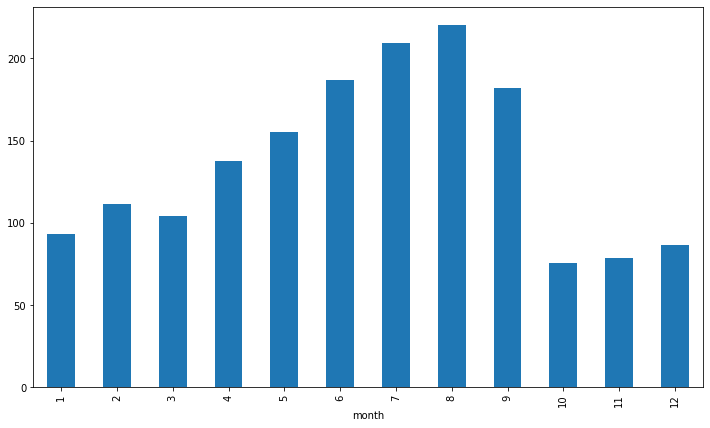

In [12]:
# Variation in traffic with months
train.groupby('month')['Count'].mean().plot.bar();

# Here there is decrease in the mean of passenger count in last three months. 


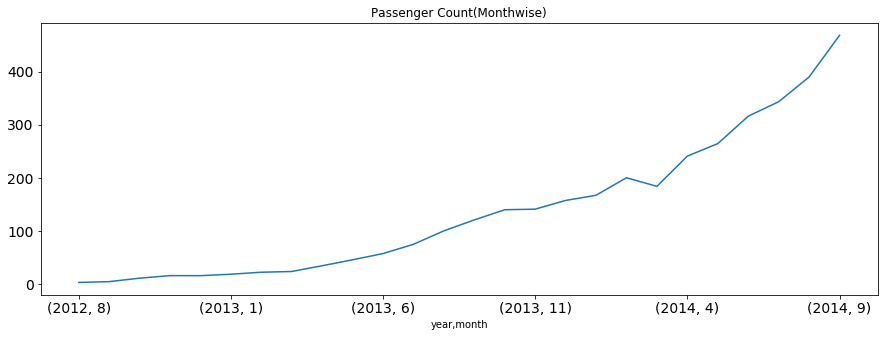

In [13]:
#  monthly mean of each year separately.
temp=train.groupby(['year', 'month'])['Count'].mean() 
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14);



### Inference
- The months 10, 11 and 12 are not present for the year 2014 and the mean value for these  months in year 2012 is very less. Since there is an increasing trend in the time series, the mean value for rest of the months will be more because of the larger passenger counts in year 2014
- Increasing trend in monthly passenger count and the growth is approximately exponential.

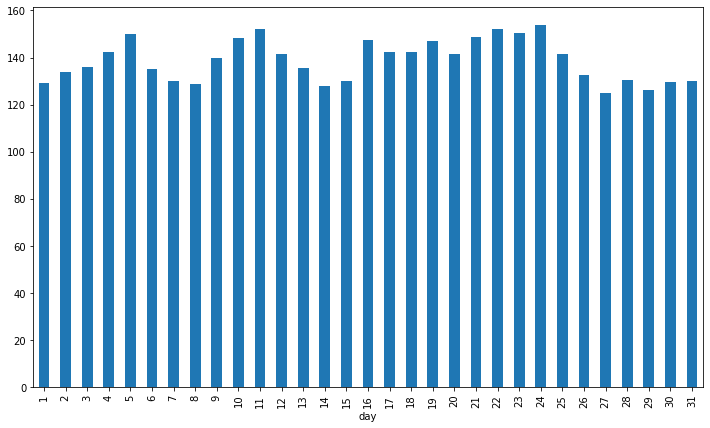

In [14]:
# The daily mean of passenger count.

plt.figure(figsize=(12,7))
train.groupby('day')['Count'].mean().plot.bar();

# Not  much insights from day wise count of the passengers.


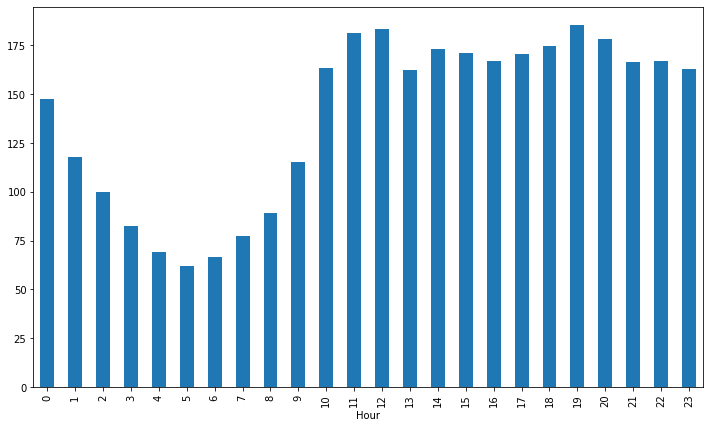

In [15]:
#  Hypothesis that the traffic will be more during peak hours. 
#  plotting the mean of hourly passenger count.

train.groupby('Hour')['Count'].mean().plot.bar();

# The peak traffic is at 7 PM and then there is a decreasing trend till 5 AM.
# After that the passenger count starts increasing again and peaks again between 11AM and 12 Noon.

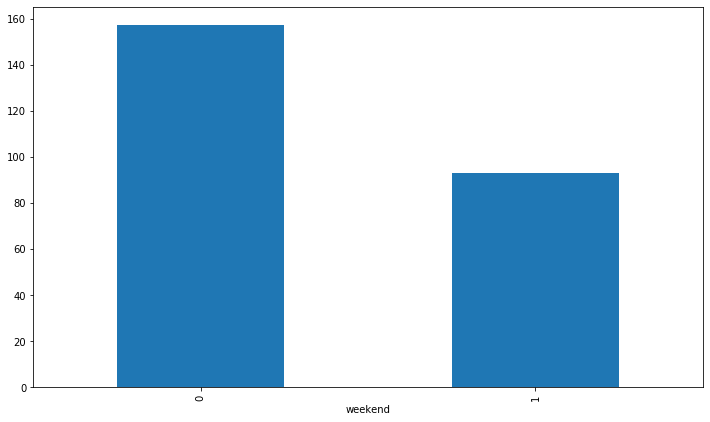

In [16]:
train.groupby('weekend')['Count'].mean().plot.bar();
# The traffic is more on weekdays as compared to weekends which validates the hypothesis.

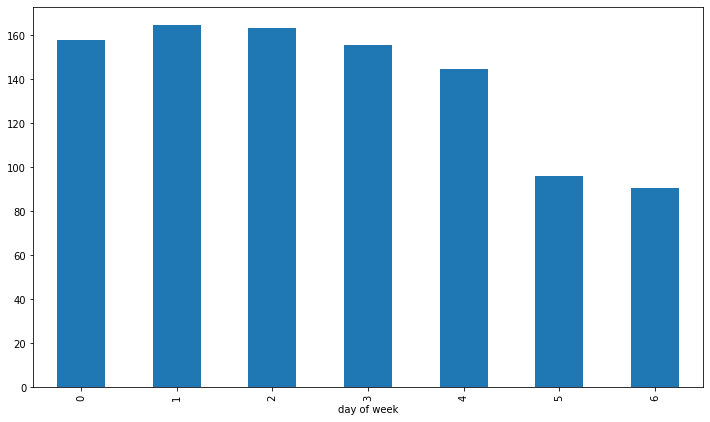

In [17]:
# Plot for day wise passenger count.

# Note - 0 is the starting of the week, i.e., 0 is Monday and 6 is Sunday.

train.groupby('day of week')['Count'].mean().plot.bar();

# The passenger count is less for saturday and sunday as compared to the other days of the week. 

In [18]:
train=train.drop('ID',1)
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train.head()

,Datetime,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,,
2012-08-25 00:00:00,2012-08-25 00:00:00,8,2012,8,25,0,5,1
2012-08-25 01:00:00,2012-08-25 01:00:00,2,2012,8,25,1,5,1
2012-08-25 02:00:00,2012-08-25 02:00:00,6,2012,8,25,2,5,1
2012-08-25 03:00:00,2012-08-25 03:00:00,2,2012,8,25,3,5,1
2012-08-25 04:00:00,2012-08-25 04:00:00,2,2012,8,25,4,5,1


**Aggregating the hourly time series to daily, weekly, and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.**

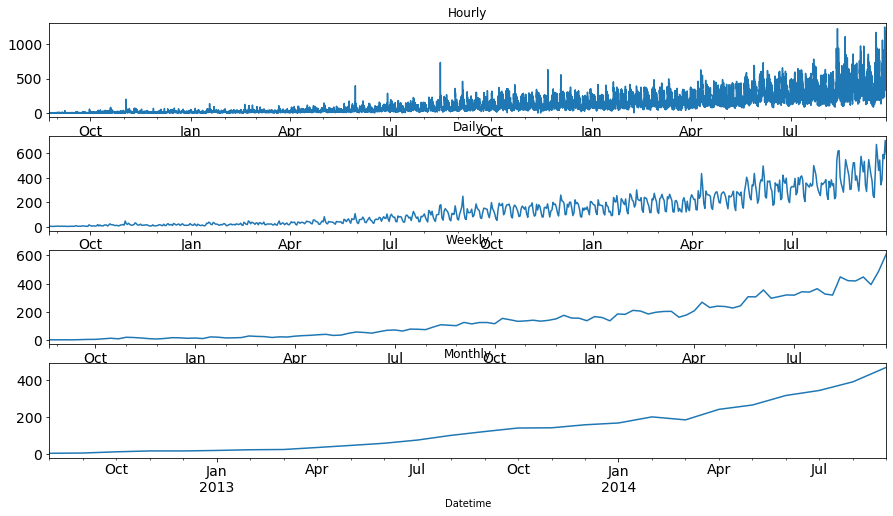

In [19]:
## Aggregating the time series 
# # Hourly time series 
hourly = train.resample('H').mean() 

# # Converting to daily mean 
daily = train.resample('D').mean() 

# # Converting to weekly mean 
weekly = train.resample('W').mean() 

# # Converting to monthly mean 
monthly = train.resample('M').mean()


# Let’s look at the hourly, daily, weekly and monthly time series.

fig, axs = plt.subplots(4,1) 

hourly.Count.plot(figsize=(15,8), title= 'Hourly', fontsize=14, ax=axs[0]) 

daily.Count.plot(figsize=(15,8), title= 'Daily', fontsize=14, ax=axs[1])

weekly.Count.plot(figsize=(15,8), title= 'Weekly', fontsize=14, ax=axs[2]) 

monthly.Count.plot(figsize=(15,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

In [20]:
# The time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.

## Aggregating the series on the daily basis because unrollling it to hourly basis is simple as compared
## to weekly or monthly basis

test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

train.head()

,Count,year,month,day,Hour,day of week,weekend
Datetime,,,,,,,
2012-08-25,3.166667,2012.0,8.0,25.0,11.5,5.0,1.0
2012-08-26,3.666667,2012.0,8.0,26.0,11.5,6.0,1.0
2012-08-27,2.583333,2012.0,8.0,27.0,11.5,0.0,0.0
2012-08-28,2.416667,2012.0,8.0,28.0,11.5,1.0,0.0
2012-08-29,2.500000,2012.0,8.0,29.0,11.5,2.0,0.0


In [21]:
df = pd.read_csv("data1/Train_SU63ISt.csv")
df_test = pd.read_csv("data1/Test_0qrQsBZ.csv")
print(f"Original Train Data Shape: {df.shape}")
print(f"Original Test Data Shape: {df_test.shape}")
print(f"Aggregated Train Data Shape: {train.shape}")
print(f"Aggregated Test Data Shape: {test.shape}")
print(f"Unrolled shape of aggregated train {train.shape[0]*24} same as og shape")

Original Train Data Shape: (18288, 3)
Original Test Data Shape: (5112, 2)
Aggregated Train Data Shape: (762, 7)
Aggregated Test Data Shape: (213, 5)
Unrolled shape of aggregated train 18288 same as og shape


## Creating Validation Set
- Taking last three months as validation sets

The starting date of the dataset is 25-08-2012 as we have seen in 
the exploration part and the end date is 25-09-2014.

In [22]:
train_df = train[train.index <= '2014-06-24']
val_df = train[train.index > '2014-06-24' ]

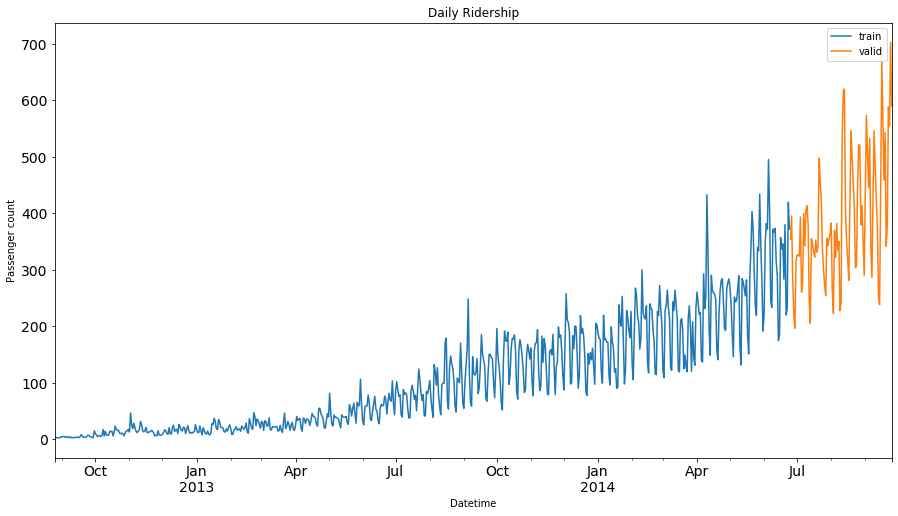

In [23]:
train_df["Count"].plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train') 
val_df["Count"].plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime") 
plt.ylabel("Passenger count") 
plt.legend(loc='best') 
plt.show()

### Basic Forecasting

* i) Naive Approach
* ii) Moving Average
* iii) Simple Exponential Smoothing
* iv) Holt’s Linear Trend Model

## 1) Naive Approach

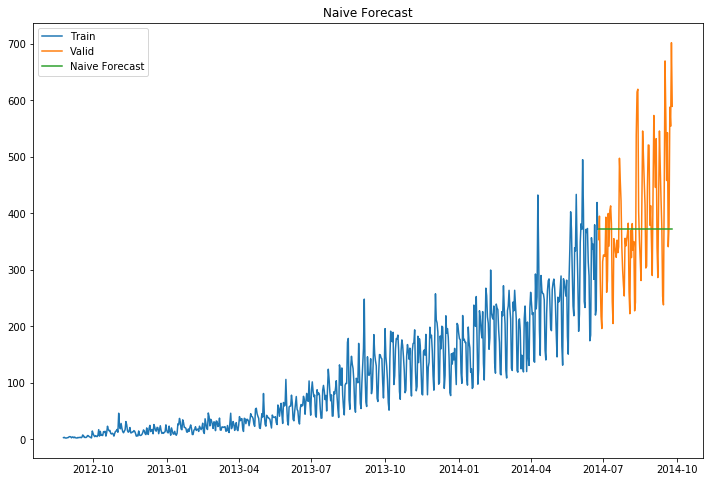

In [24]:
# In this forecasting technique, we assume that the next expected point is equal to the last observed point. 
# i.e drawing a straight horizontal line as the prediction.

dd = np.asarray(train_df.Count) 
y_hat = val_df.copy() 
y_hat['naive'] = dd[len(dd)-1] 
plt.figure(figsize=(12,8)) 
plt.plot(train_df.index, train_df['Count'], label='Train') 
plt.plot(val_df.index,val_df['Count'], label='Valid') 
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast') 
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()
## The green line is the predictions for the validation data

In [25]:
# Calculating RMSE to check the accuracy of our model on validation data set.

from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(val_df.Count, y_hat.naive)) 
print(f"RMSE for Naive Foreacsting: {rms}")


RMSE for Naive Foreacsting: 111.79050467496724


## 2. MOVING AVERAGE

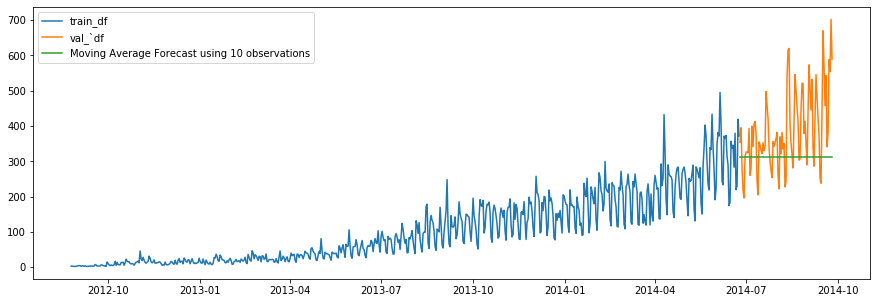

RMSE for Moving Avergae: 134.23733308950264


In [26]:
# In this technique we take the average of the passenger counts for last few time periods only.

y_hat_avg = val_df.copy() 
y_hat_avg['moving_avg_forecast'] = train_df['Count'].rolling(10).mean().iloc[-1] # average of last 10 observations. 
plt.figure(figsize=(15,5)) 
plt.plot(train_df['Count'], label='train_df') 
plt.plot(val_df['Count'], label='val_`df') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations') 
plt.legend(loc='best') 
plt.show() 

rms = sqrt(mean_squared_error(val_df.Count, y_hat_avg.moving_avg_forecast)) 
print(f"RMSE for Moving Avergae: {rms}")


## The big rmse is due to because the mean of last 3 months are very high as seen in the above plots and 
## I tooked mean of ten days for the 11 th day which has small mean as comapred to last three months . hence
## the green line is below the normal mean resulting in gretater rmse


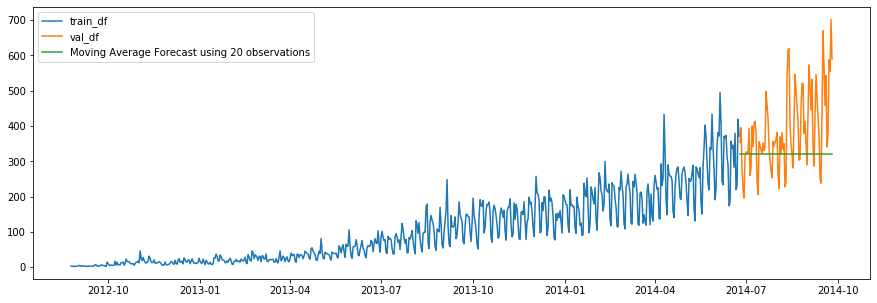

RMSE for Moving Avergae(20): 130.44984977550422


In [27]:
# average of last 20 observations. 
y_hat_avg = val_df.copy() 
y_hat_avg['moving_avg_forecast'] = train_df['Count'].rolling(20).mean().iloc[-1] 
plt.figure(figsize=(15,5)) 
plt.plot(train_df['Count'], label='train_df') 
plt.plot(val_df['Count'], label='val_df') 
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations') 
plt.legend(loc='best') 
plt.show() 

rms = sqrt(mean_squared_error(val_df.Count, y_hat_avg.moving_avg_forecast)) 
print(f"RMSE for Moving Avergae(20): {rms}")


## SIMPLE EXPONENTIAL SMOOTHENING

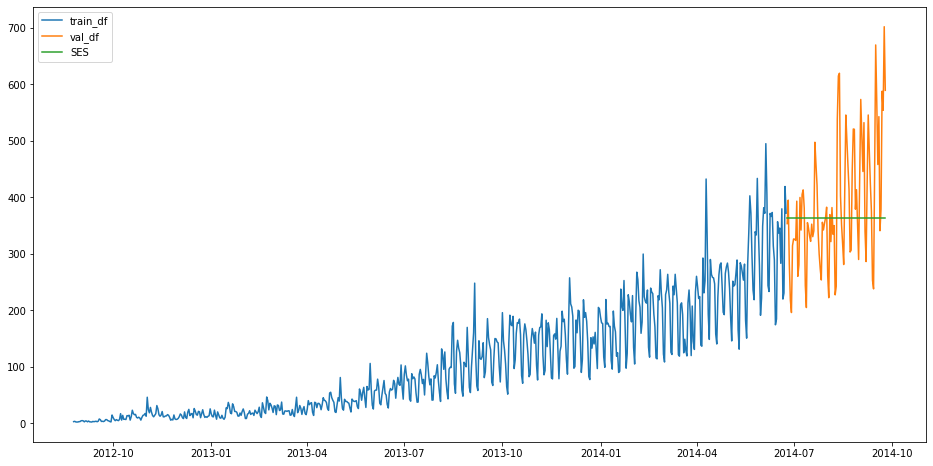

RMSE for Exponential Smoothening: 113.43708111884514


In [28]:
# Here the predictions are made by assigning larger weight to the recent values and 
# lesser weight to the old values.

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt 
y_hat_avg = val_df.copy() 
fit2 = SimpleExpSmoothing(np.asarray(train_df['Count'])).fit(smoothing_level=0.6,optimized=False) 
y_hat_avg['SES'] = fit2.forecast(len(val_df)) 
plt.figure(figsize=(16,8)) 
plt.plot(train_df['Count'], label='train_df') 
plt.plot(val_df['Count'], label='val_df') 
plt.plot(y_hat_avg['SES'], label='SES') 
plt.legend(loc='best') 
plt.show()


rms = sqrt(mean_squared_error(val_df.Count, y_hat_avg.SES)) 
print(f'RMSE for Exponential Smoothening: {rms}')

# The fit of the model his better than above techniques

## Holt’s Linear Trend Model
- It is an extension of simple exponential smoothing to allow forecasting of data with a trend.
- This method takes into account the trend of the dataset. The forecast function in this method is a function of level and trend.


**We can decompose the time series in three parts.**
> TS = Trend + Seasonal + Residual(error)

- Observed, which is the original time series.
- Trend, which shows the trend in the time series, i.e., increasing or decreasing behaviour of the time series.
- Seasonal, which tells us about the seasonality in the time series (periodic repitition of pattern)
- Residual, which is obtained by removing any trend or seasonality in the time series.



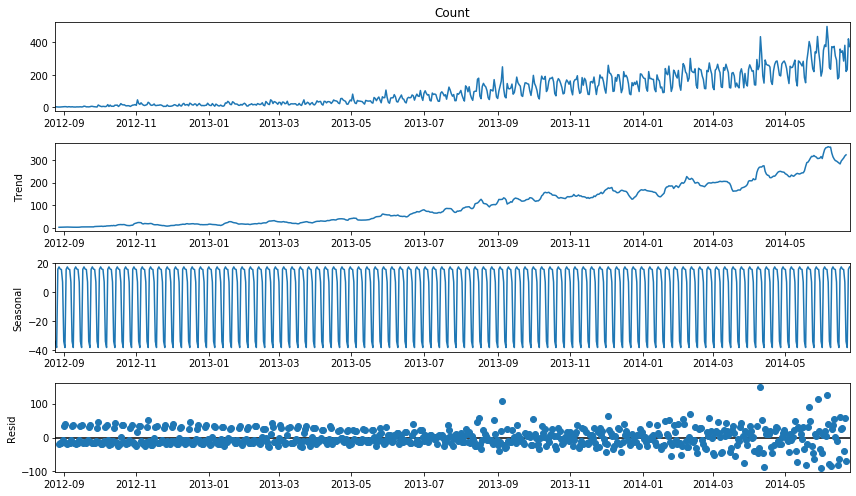

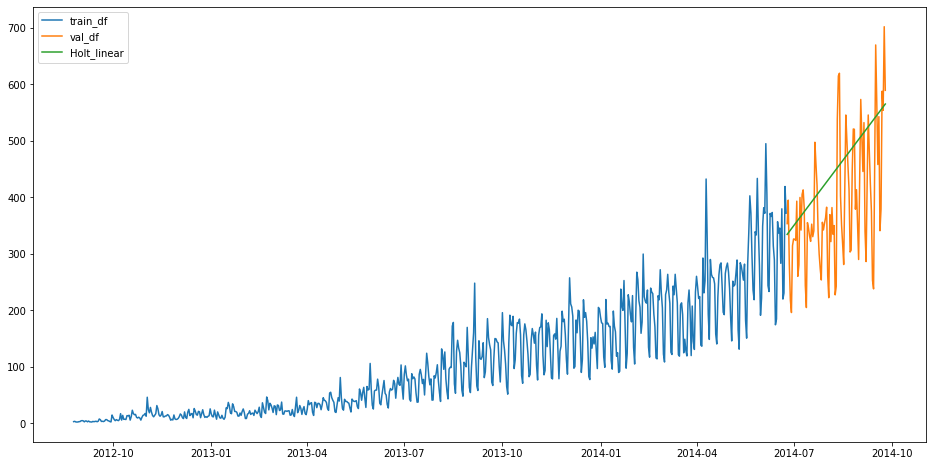

RMSE for Holt = 112.94278345314041


In [29]:
## Visualizing Time Series Components

sm.tsa.seasonal_decompose(train_df.Count).plot() 
plt.show()

# An increasing trend can be seen in the dataset, so now we will make a model based on the trend.

y_hat_avg = val_df.copy() 
fit1 = Holt(np.asarray(train_df['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1) 
y_hat_avg['Holt_linear'] = fit1.forecast(len(val_df)) 
plt.figure(figsize=(16,8)) 
plt.plot(train_df['Count'], label='train_df') 
plt.plot(val_df['Count'], label='val_df') 
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear') 
plt.legend(loc='best') 
plt.show()


# We see an inclined line here as the model has taken into consideration the trend of the time series.


rms = sqrt(mean_squared_error(val_df.Count, y_hat_avg.Holt_linear)) 
print(f'RMSE for Holt = {rms}')



# ALL DATA PREPROCESSING IN ONE PLACE

In [53]:
train = pd.read_csv("data1/Train_SU63ISt.csv")
test = pd.read_csv("data1/Test_0qrQsBZ.csv")

train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 

train_original = train.copy()
test_original = test.copy()


test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M') 
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 
    
    
train['day of week']=train['Datetime'].dt.dayofweek 
# Let’s assign 1 if the day of week is a weekend and 0 if the day of week in not a weekend.

def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0 
temp2 = train['Datetime'].apply(applyer) 
train['weekend']=temp2



test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean() 

train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
# Converting to daily mean 
train = train.resample('D').mean()

print(train.shape)

(762, 8)


# HOLT WINTER’S MODEL ON DAILY TIME SERIES
* Datasets which show a similar set of pattern after fixed intervals of a time period suffer from seasonality.

* The above mentioned models don’t take into account the seasonality of the dataset while forecasting.

* One such algorithm that takes into account seasonality with trend  is Holt’s Winter method. The idea behind Holt’s Winter is to apply exponential smoothing to the seasonal components in addition to level and trend.


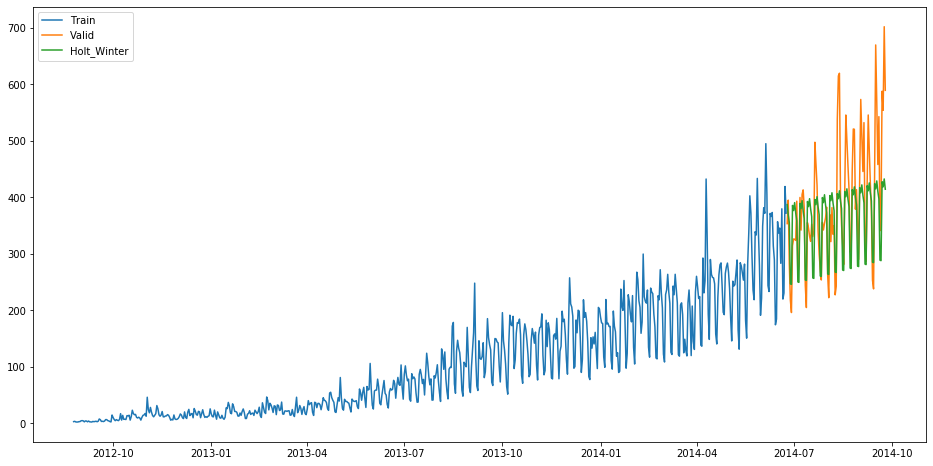

82.3757938887814


In [54]:
Train = train[train.index <= '2014-06-24']
valid = train[train.index > '2014-06-24' ]

y_hat_avg = valid.copy() 
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add').fit() 
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid)) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter') 
plt.legend(loc='best') 
plt.show()
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter)) 
print(rms)

## The rmse value has reduced a lot from this method.


# Introduction to ARIMA model

> * `ARIMA` stands for **Auto Regression Integrated Moving Average.** 
> * It is specified by three ordered parameters (p,d,q).
> * Here p is the order of the autoregressive model(number of time lags)
> * d is the degree of differencing(number of times the data have had past values subtracted)
> * q is the order of moving average model. We will discuss more about these parameters in next section.

**The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation.**

### What is a stationary time series?
There are three basic criterion for a series to be classified as stationary series :

* The mean of the time series should not be a function of time. It should be constant.
* The variance of the time series should not be a function of time.
* The covariance of the ith term and the (i+m)th term should not be a function of time.

### Why do we have to make the time series stationary?
We make the series stationary to make the variables independent. Variables can be dependent in various ways, but can only be independent in one way. So, we will get more information when they are independent. Hence the time series must be stationary.

If the time series is not stationary, firstly we have to make it stationary. For doing so, we need to remove the trend and seasonality from the data. <br>


### Stationarity Check

We use Dickey Fuller test to check the stationarity of the series.

* The intuition behind this test is that it determines how strongly a time series is defined by a trend.
* The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
* The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
* The test results comprise of a Test Statistic and some Critical Values for difference confidence levels.  
* If the **‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.**

We interpret this result using the Test Statistics and critical value. If the Test Statistics is smaller than critical value, it suggests we reject the null hypothesis (stationary), otherwise a greater Test Statistics suggests we accept the null hypothesis (non-stationary).

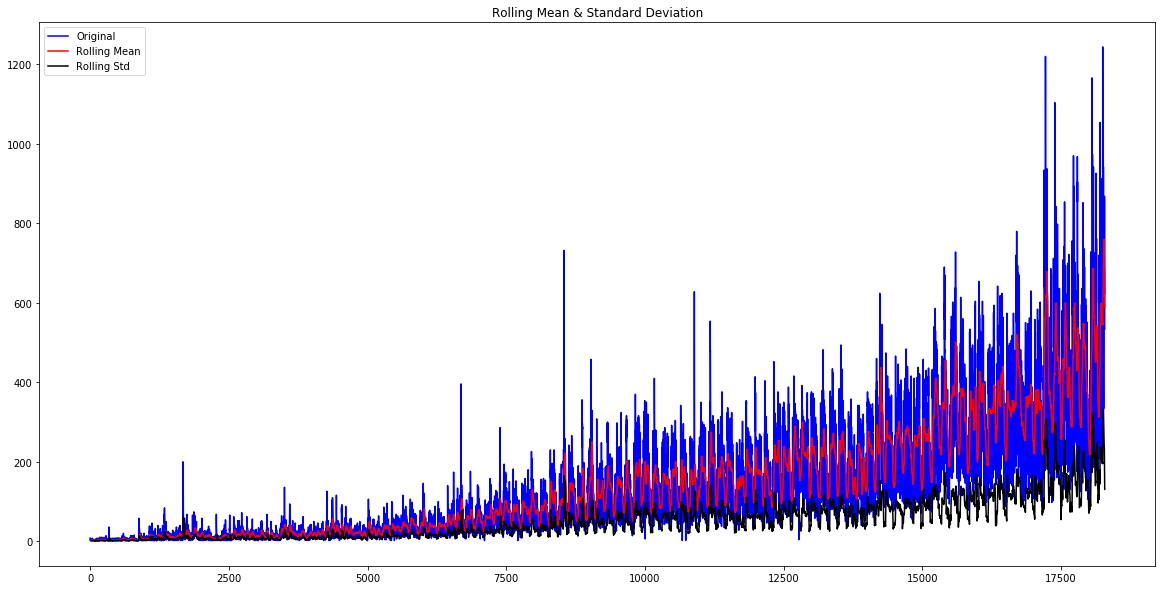

ADF Test Statistic : -4.456560536856825
p-value : 0.00023540466467665176
#Lags Used : 45
Number of Observations Used : 18242
Strong evidence against the null hypothesis(Ho), reject the null hypothesis.Time Series is stationary


In [55]:
from statsmodels.tsa.stattools import adfuller 

def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean() # 24 hours on each day
    rolstd = timeseries.rolling(24).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    #Perform Dickey-Fuller test:
    result=adfuller(timeseries)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis.Time Series is stationary")
    else:
        print("Weak evidence against null hypothesis, Time Series is non-stationary ")


from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 20,10
test_stationarity(train_original['Count'])

# Removing Trend

* We see an increasing trend in the data so we can apply transformation which penalizes higher values more than smaller ones, for example log transformation.

* Taking rolling average here to remove the trend. Taking the window size of 24 based on the fact that each day has 24 hours.


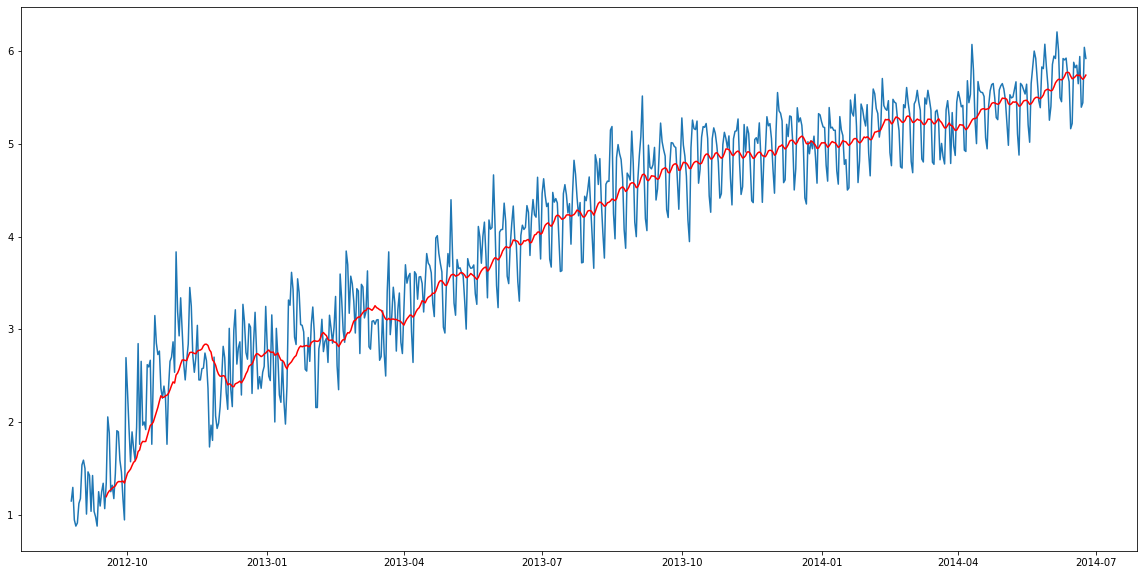

In [56]:
Train_log = np.log(Train['Count']) 
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean() 
plt.plot(Train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

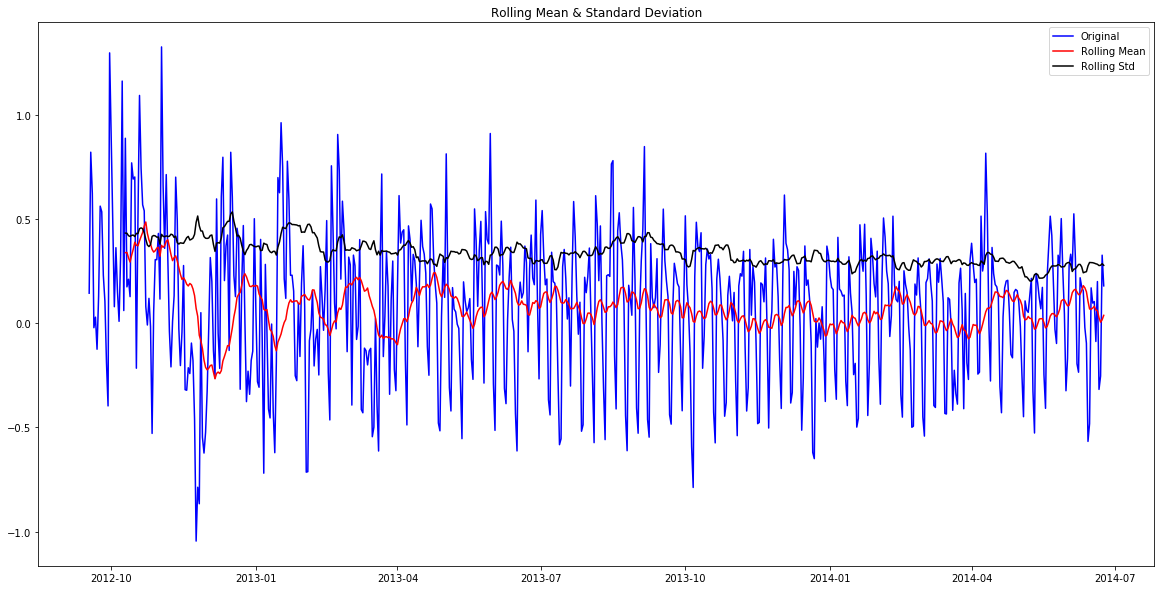

ADF Test Statistic : -5.861645522775965
p-value : 3.3994222693861207e-07
#Lags Used : 20
Number of Observations Used : 625
Strong evidence against the null hypothesis(Ho), reject the null hypothesis.Time Series is stationary


In [58]:
## REMOVING TREND

train_log_moving_avg_diff = Train_log - moving_avg

# rolling mean is not defined for the first 23 values because we took mean of first n-24 values for nth value  
# So let’s drop those null values.

train_log_moving_avg_diff.dropna(inplace = True) 
test_stationarity(train_log_moving_avg_diff)

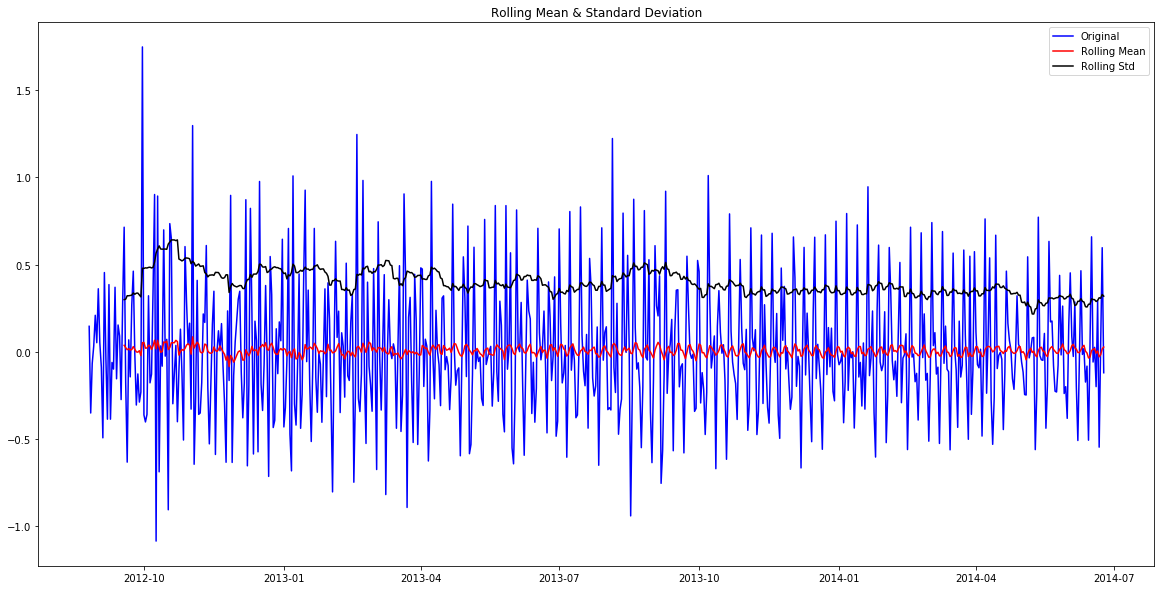

ADF Test Statistic : -8.237567849678873
p-value : 5.834049398271651e-13
#Lags Used : 19
Number of Observations Used : 648
Strong evidence against the null hypothesis(Ho), reject the null hypothesis.Time Series is stationary


In [60]:
# Stabilizing the mean of the time series which is also a requirement for a stationary time series.
# Differencing helps to make the series stable and eliminate the trend.


train_log_diff = Train_log - Train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

# Removing Seasonality
* By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
* Seasonality is always of a fixed and known period.
* Using seasonal decompose to decompose the time series into trend, seasonality and residuals.

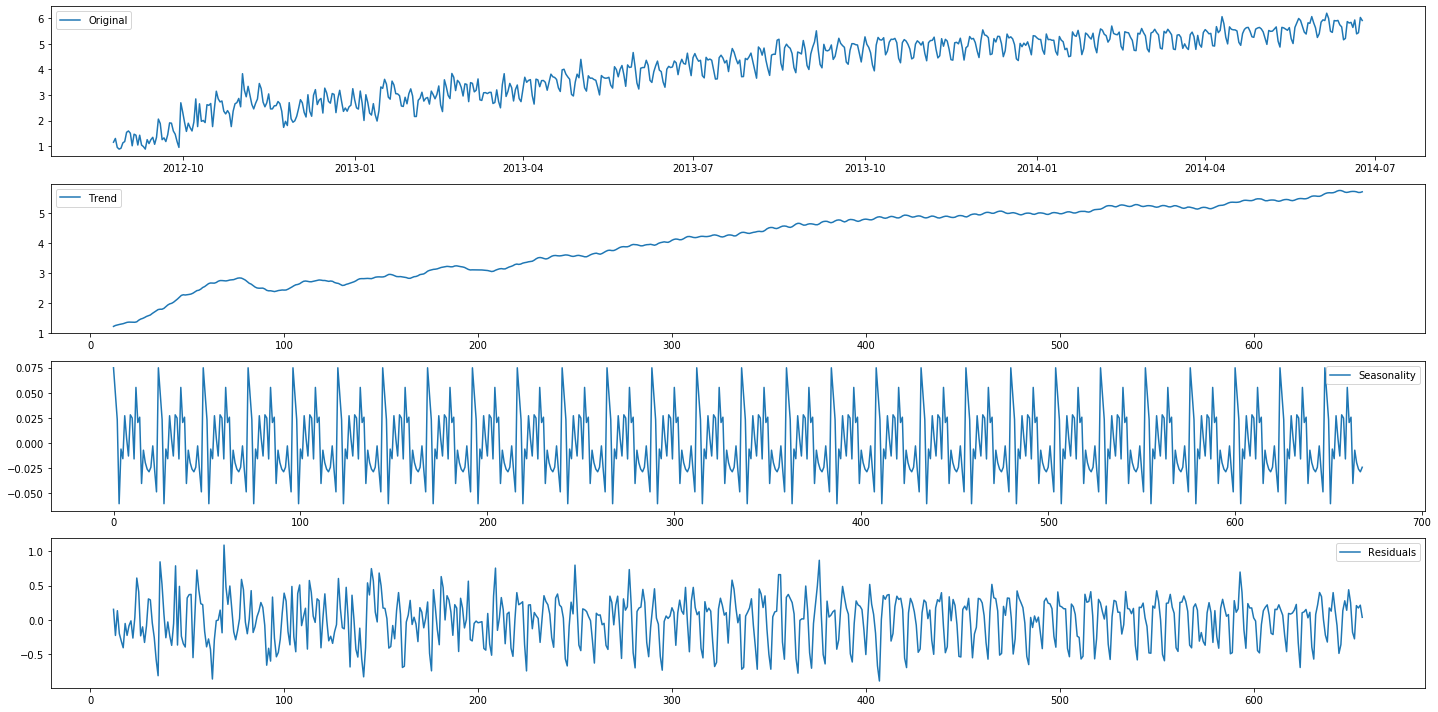

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose 

decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24) 

trend = decomposition.trend 
seasonal = decomposition.seasonal 
residual = decomposition.resid 

plt.subplot(411) 
plt.plot(Train_log, label='Original') 
plt.legend(loc='best') 
plt.subplot(412) 
plt.plot(trend, label='Trend') 
plt.legend(loc='best') 
plt.subplot(413) 
plt.plot(seasonal,label='Seasonality') 
plt.legend(loc='best') 
plt.subplot(414) 
plt.plot(residual, label='Residuals') 
plt.legend(loc='best') 
plt.tight_layout() 
plt.show()

# The trend, residuals and the seasonality can be clearly seen in the  graph. 
# Seasonality shows a constant trend in counter.


## ACF and PACF plots
- To decide the order of P and Q for ARIMA

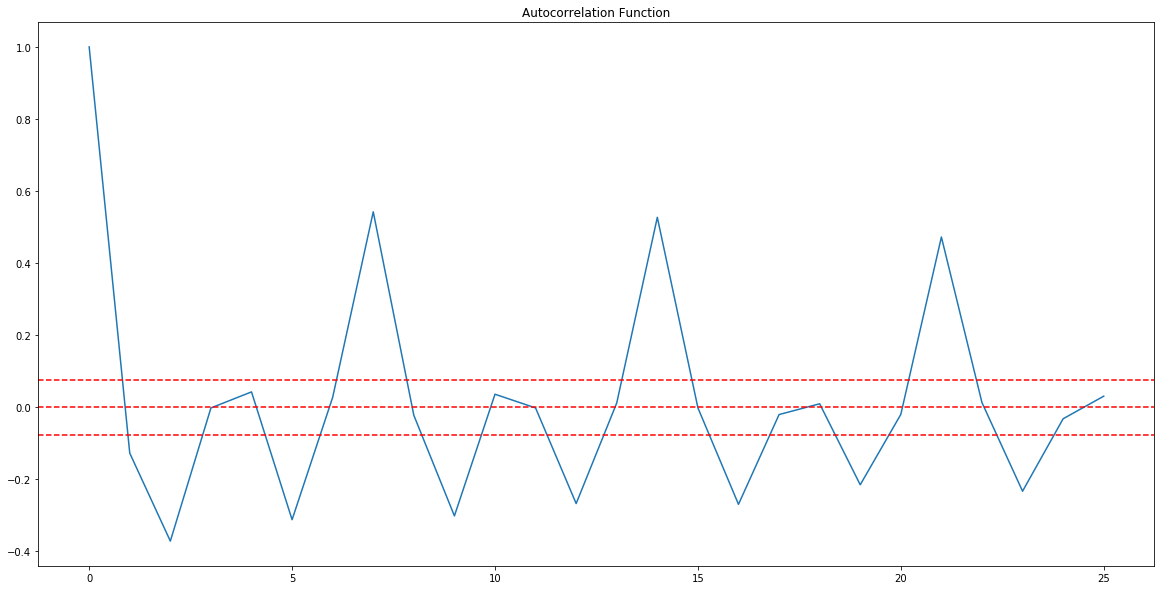

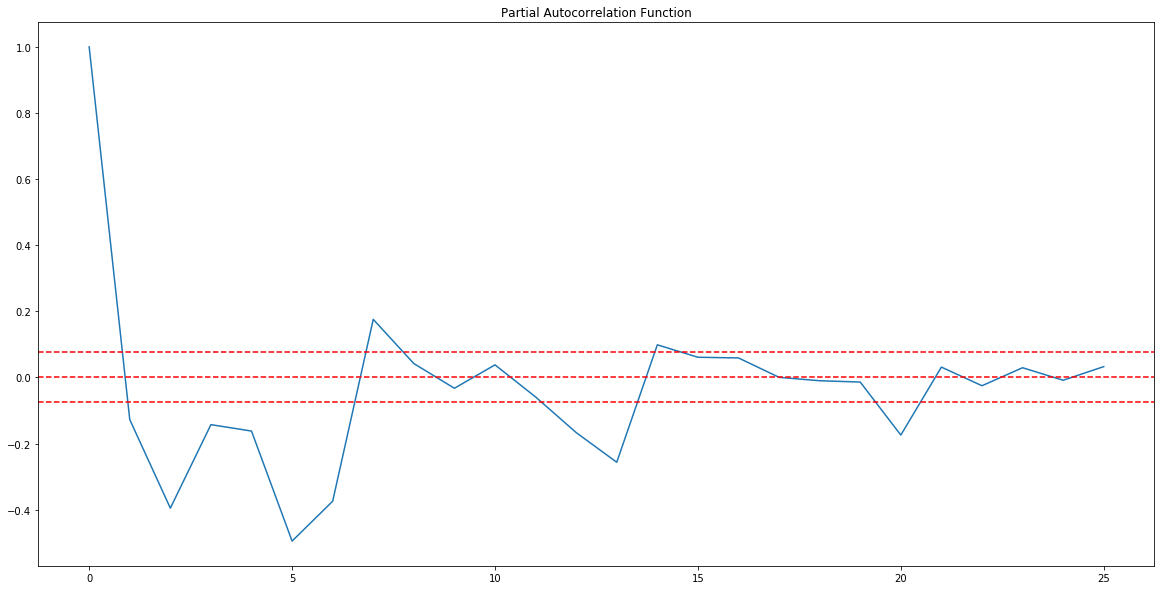

In [62]:
from statsmodels.tsa.stattools import acf, pacf 
lag_acf = acf(train_log_diff.dropna(), nlags=25) 
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

plt.plot(lag_acf) 
plt.axhline(y=0,linestyle='--',color='red') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='red') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='red') 
plt.title('Autocorrelation Function') 
plt.show() 

plt.plot(lag_pacf) 
plt.axhline(y=0,linestyle='--',color='red') 
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='red') 
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='red') 
plt.title('Partial Autocorrelation Function') 
plt.show()

## Inference from PACF and ACF plots
- From the ACF graph, the curve touches y=0.0 line at x=1. Thus, from theory, Q = 1 
- From the PACF graph, the curve touches y=0.0 line at x=1. Thus, from theory, P = 1


## AR model
* The autoregressive model specifies that the output variable depends linearly on its own previous values.

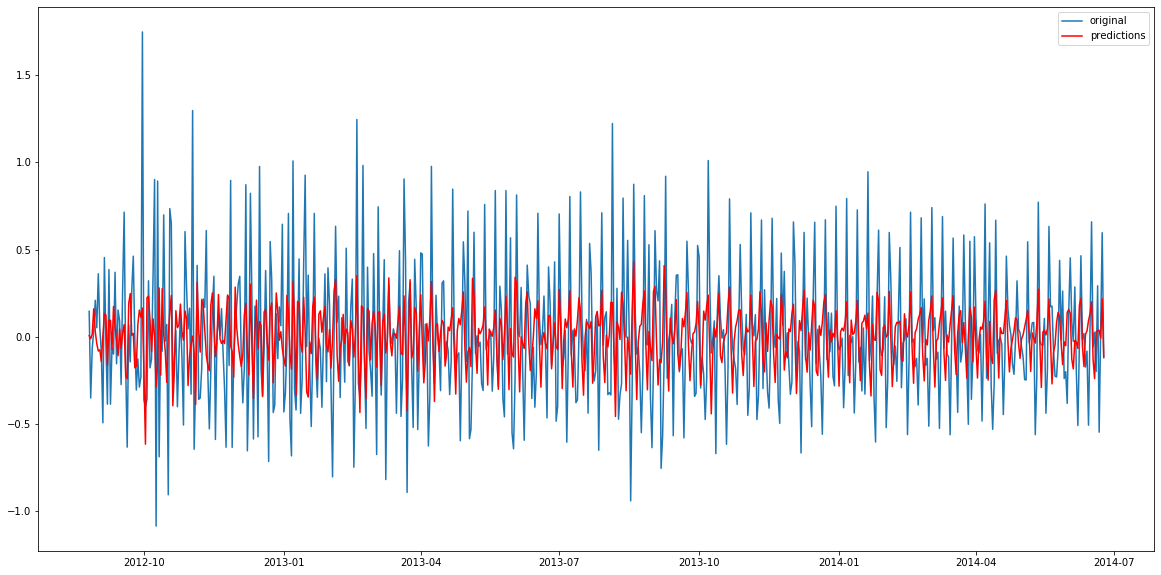

In [63]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model 
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_AR.fittedvalues, color='red', label='predictions') 
plt.legend(loc='best') 
plt.show()

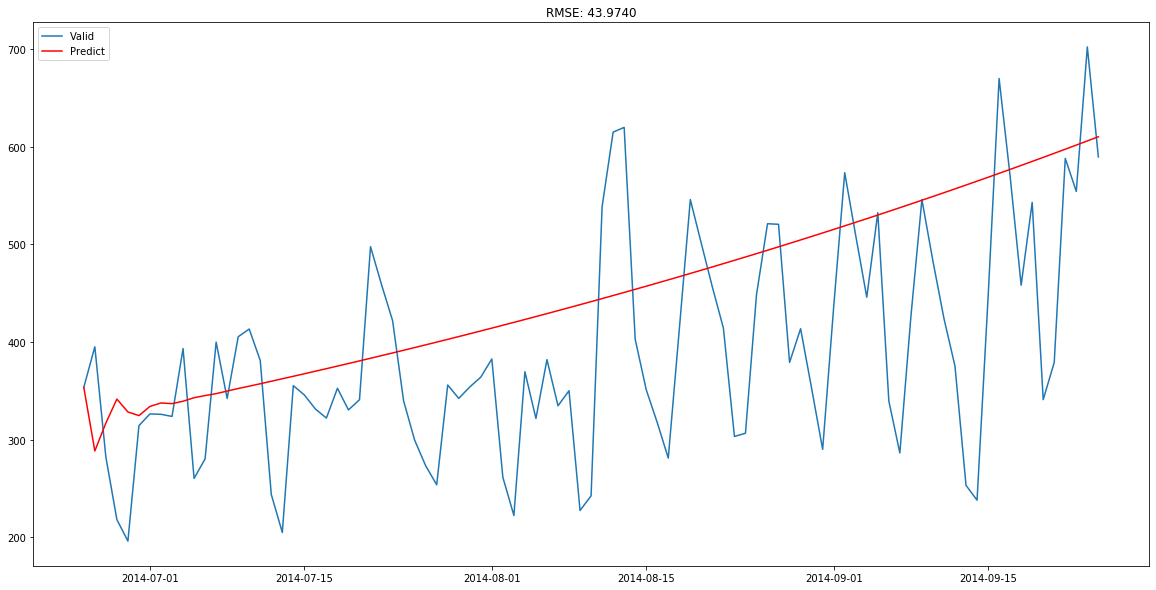

In [64]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25") 
AR_predict=AR_predict.cumsum().shift().fillna(0) 
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
AR_predict1=AR_predict1.add(AR_predict,fill_value=0) 
AR_predict = np.exp(AR_predict1)
plt.plot(valid['Count'], label = "Valid") 
plt.plot(AR_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0])) 
plt.show()



# MA MODEL
The moving-average model specifies that the output variable depends linearly on the current and various past values of a stochastic (imperfectly predictable) term.


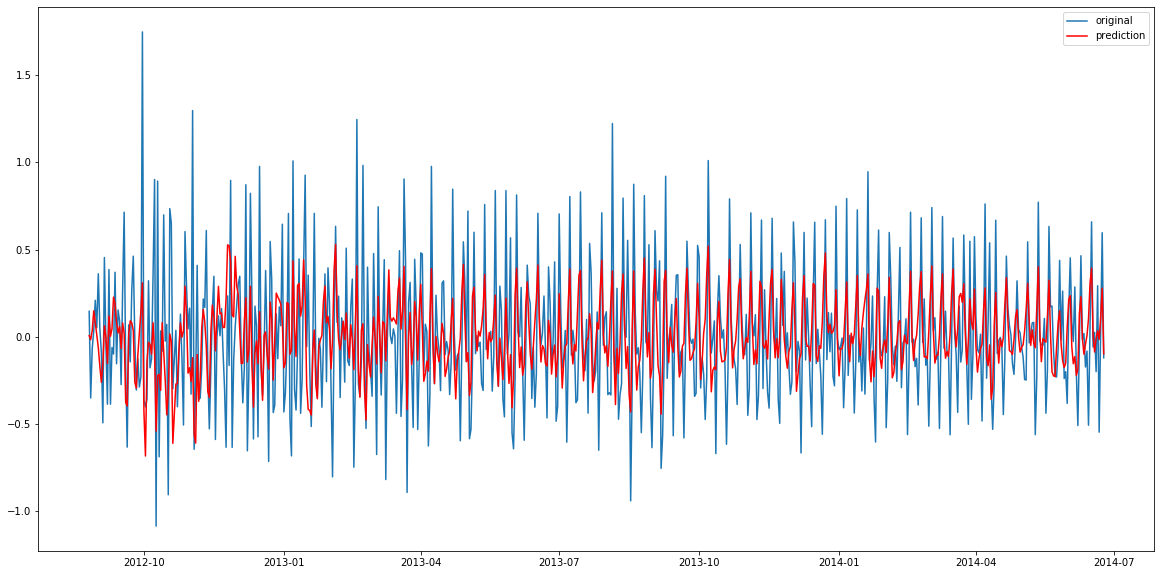

In [69]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model 
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original') 
plt.plot(results_MA.fittedvalues, color='red', label='prediction') 
plt.legend(loc='best') 
plt.show()

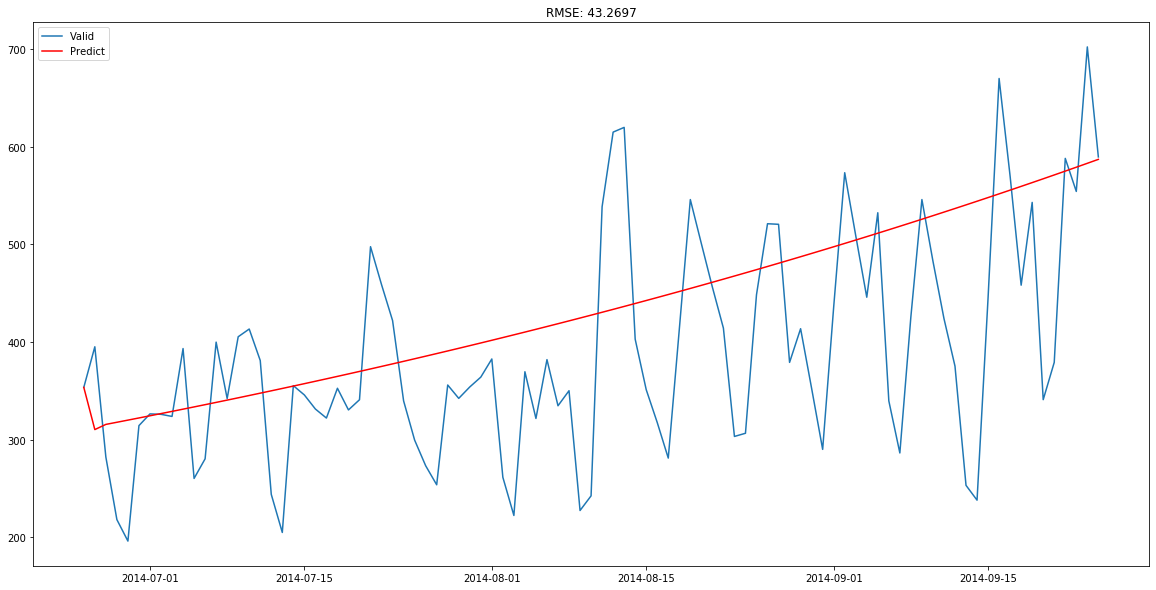

In [70]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25") 
MA_predict=MA_predict.cumsum().shift().fillna(0) 
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index) 
MA_predict1=MA_predict1.add(MA_predict,fill_value=0) 
MA_predict = np.exp(MA_predict1)
plt.plot(valid['Count'], label = "Valid") 
plt.plot(MA_predict, color = 'red', label = "Predict") 
plt.legend(loc= 'best') 
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0])) 
plt.show()

## COMBINED MODEL (AR & MA into ARIMA)

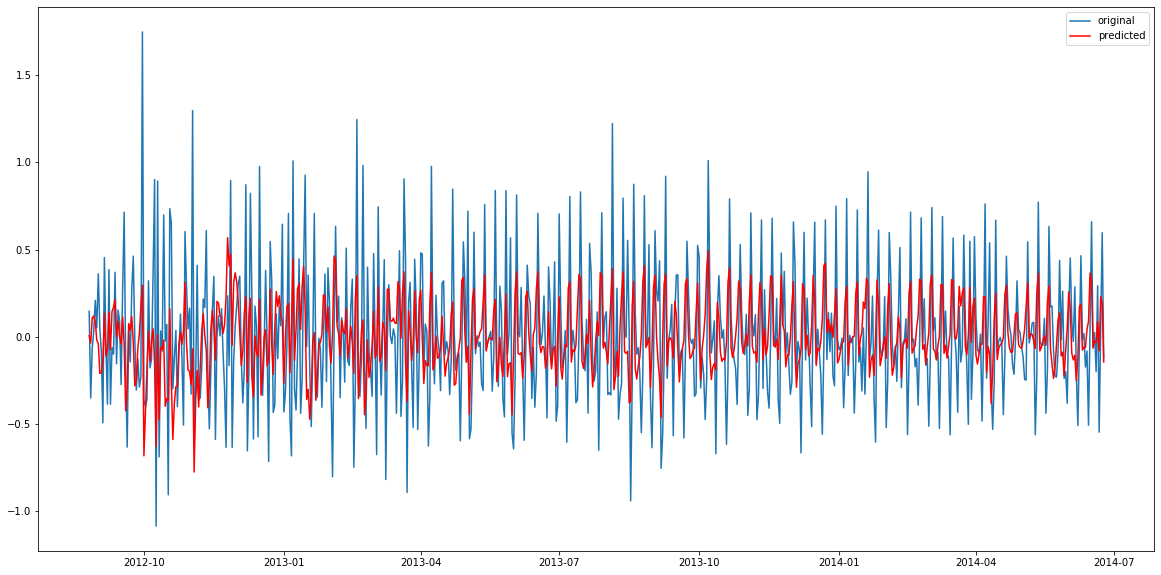

In [72]:
model = ARIMA(Train_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original') 
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted') 
plt.legend(loc='best') 
plt.show()

# SARIMAX MODEL
SARIMAX model takes into account the seasonality of the time series.

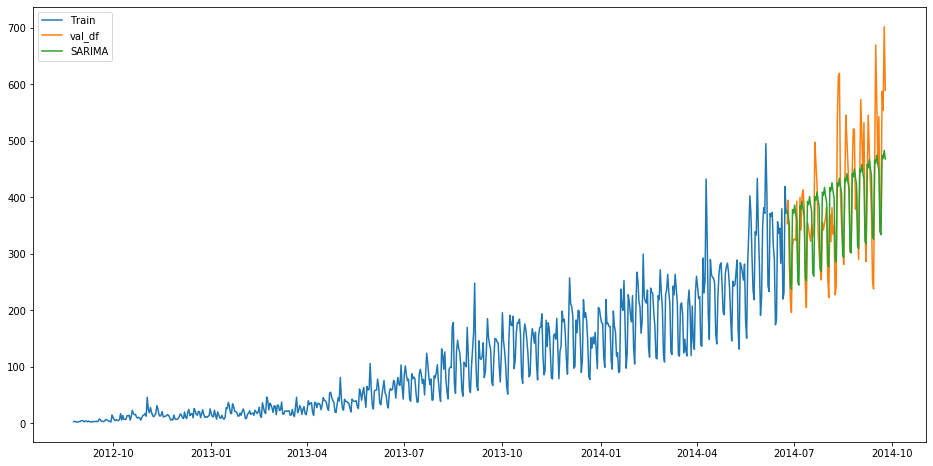

In [120]:
y_hat_avg = val_df.copy() 
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(val_df['Count'], label='val_df') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()



# Order in the above model represents the order of the autoregressive model(number of time lags), 
# the degree of differencing(number of times the data have had past values subtracted) and the order
# of moving average model.

# Seasonal order represents the order of the seasonal component of the model for the AR parameters,
# differences, MA parameters, and periodicity.

# Here the periodicity is 7 since it is daily time series and will repeat after every 7 days.


##  SARIMAX MODEL
SARIMAX model takes into account the seasonality of the time series. So we will build a SARIMAX model on the time series.

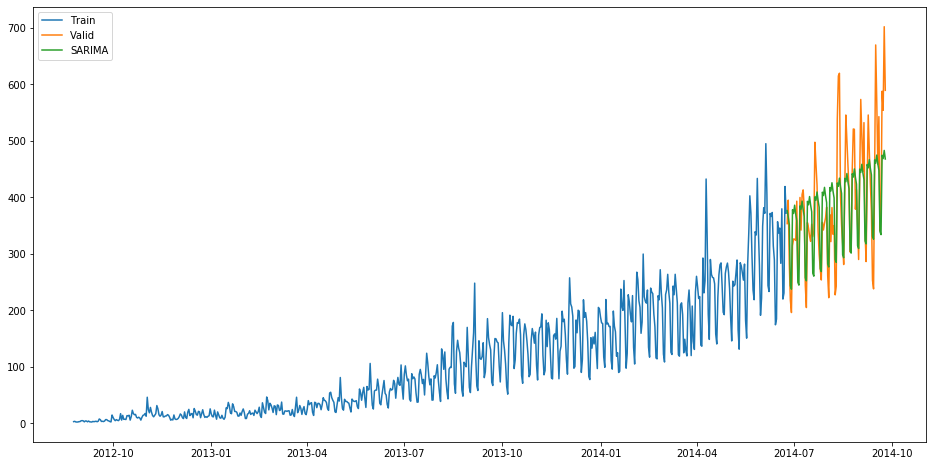

In [74]:
y_hat_avg = valid.copy() 
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit() 
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True) 
plt.figure(figsize=(16,8)) 
plt.plot( Train['Count'], label='Train') 
plt.plot(valid['Count'], label='Valid') 
plt.plot(y_hat_avg['SARIMA'], label='SARIMA') 
plt.legend(loc='best') 
plt.show()



# Order in the above model represents the order of the autoregressive model(number of time lags), 
# the degree of differencing(number of times the data have had past values subtracted) and the order
# of moving average model.

# Seasonal order represents the order of the seasonal component of the model for the AR parameters,
# differences, MA parameters, and periodicity.

# Here periodicity is 7 since it is daily time series and will repeat after every 7 days.


In [79]:
# Forecasting the time series for Test data which starts from 2014-9-26 and ends at 2015-4-26.

rms = sqrt(mean_squared_error(val_df.Count, y_hat_avg.SARIMA)) 
print(f'SARIMA RMS = {rms}')


# Calculating the hourly ratio of count 
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 

# Grouping the hourly ratio 
temp = train_original.groupby(['Hour'])['ratio'].sum() 

# Groupby to csv format 
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('data1/GROUPBY.csv') 

temp2=pd.read_csv("data1/GROUPBY.csv") 
temp2=temp2.drop('Hour.1',1) 

predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)

# Distributing the daily basis prediction into hourly basis by multplying 
# it with ratio of  hourly distribution of passenger count from train data 

test['prediction']=predict
# Merge Test and test_original on day, month and year 
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left') 
merge['Hour']=merge['Hour_y'] 
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1) 

# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left') 

# Converting the ratio to the original scale 
prediction['Count']=prediction['prediction']*prediction['ratio']*24


# dropping all variables other than ID and Count
prediction['ID']=prediction['ID_y'] 
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1) 

# Converting the final submission to csv format 
ans = pd.DataFrame(submission, columns=['ID','Count'])
subm = pd.DataFrame(submission, columns=['ID','Count'])


SARIMA RMS = 69.52999647142646


In [80]:
subm

,ID,Count
0,18288,484.925112
1,18289,386.995609
2,18290,327.517483
3,18291,270.615995
4,18292,227.778301
...,...,...
5107,23395,784.486853
5108,23396,753.864773
5109,23397,703.652997
5110,23398,706.205762
